# Frequency Domain Adaptive Filtering for Acoustic Echo Cancellation
**Supervisor** | Michael Günther, M.Sc <br>
**Prepared by**  | Unal Ege Gaznepoglu & Jan Wilczek<br>
**Matrikel Nr**   | 22746880 & 22736060<br>
**E-mail Addr**        | ege.gaznepoglu@fau.de & jan.wilczek@fau.de<br>

## 1. Introduction & Motivation

Acoustic Echo Cancellation (AEC) is a long-worked problem for which many algorithms have been developed. The visual below illustrates the problem:

![Figure 1: Acoustic Echo Cancellation problem description](./Images/Fig1-AECdesc.png "Figure 1: Acoustic Echo Cancellation problem.")

Given $x(n)$ and $d(n)$, we wish to extract $e(n)$. This is possible with an adaptive filter $\hat{h}(n)$ which should replicate the actual environment's impulse response $h(n)$. Ignoring any non-linearities, there are various algorithms which solve the problem, one being Least Mean-Squares (LMS). LMS is a time-domain algorithm and we have realized its implementation during the 5th PrStaSip laboratory session. Variations include the block-LMS algorithm which updates the filter coefficients once per block of new samples instead of every sample.

However, a drawback of LMS is the fast-growing complexity with the impulse response length. The fast Fourier transform allows more efficient filtering in frequency domain, so a frequency-domain complement - Frequency Domain Adaptive Filtering (FDAF) has been described by Shynk [1]. 

With the adaptive algorithms, a new problem emerges: when one should 'adapt' the filter and when one should not. From our experience in related PrStaSiP session, we discovered that adaptation during double-talk (both far-end and near-end speakers active at the same time) severely degrades the algorithm's performance. This is to be expected as during double-talk the $e(n)$ has two components: one resulting from inadequate adaptation filter's estimate and the other coming from the near-end speaker. The latter carries no information regarding $h(n)$, yet affects the update. To summarize, we have to stop adaptation whenever we detect double-talk.

In laboratory session, for this purpose, we used a parameter called `freeze_index`, which stops the adaptation after a fixed number of samples. As it is impossible to know ahead when precisely adaptation should be put on hold during real-time filtering (e.g. while performing hands-free communication) a separate algorithm for detecting double-talk must be implemented. For this purpose, we have chosen a double-talk detector (DTD) using excitation-weighted mean magnitude square coherence based on [3].

## 2. Notation

### 2.1 Vectors, Matrices, Scalars
$ F_N :$ FFT matrix of size (N x N)

$ {x} :$ Time domain vector

$ {A} :$ Time domain matrix

$ \mathbf{x} :$ Frequency domain vector

$ \mathbf{A} :$ Frequency domain matrix

### 2.2 Operators

$ * $ : convolution

$ \odot $ : elementwise product (Hadamard product)

$ {\{\}}^H $ : Hermitian (elementwise complex conjugate)

### 2.3 Symbol Definitions


| Desc. | Time-Domain | Frequency-Domain |
|------|------|------|
|Filter coefficients | $h(n)$ | $\mathbf{h}(n)$ |
|Loudspeaker signal | $x(n)$ | $\mathbf{x}(n)$, $\mathbf{X}(n)$ |
|Microphone signal | $d(n)$ | $\mathbf{d}(n)$ |
|Filter output | $y(n)$ | $\mathbf{y}(n)$ |
|Error signal | $e(n)$ | $\mathbf{e}(n)$ |
|PSD estimate | N/A | $\mathbf{p_x}(n)$ |
|Learning rate | N/A | $\mathbf{M}(n)$ |

For notational convenience (to be able to use matrix products all the time), we denote $\mathbf{X}(n)$ as frequency domain diagonal matrix with elements of $\mathbf{x}(n)$ on the main diagonal.

| Symbol | Definition | Desc |
|---|---|---|
|$G_{2N \times 2N}$ | $\begin{bmatrix} I_N & 0\\ 0 & 0  \end{bmatrix}$ | Gradient constraint #1
|$K_{N \times 2N}$ | $\begin{bmatrix}  0 & I_N\end{bmatrix}$ | Gradient constraint #2


### 2.4 Parameters

| Symbol | Desc.|
|------|-------|
|Block length| $2N$|
|Shift count | $N$|
|PSD leak factor| $\lambda$|
|Learning rate multiplier| $\mu$|
|PSD leak factor for coherence calculation| $\lambda_c$ |
|Double-talk detection threshold (open-loop)| $T_{ol}$ |
|Double-talk detection threshold (closed-loop)| $T_{cl}$ |

## 2. LMS, FDAF and EMCD - Theory

### 2.1 LMS

All the LMS variants (block and non-block - time domain) try to minimize the MSE.

$ \zeta = E[e^2(n)]$, where $e(n) = d(n) - \hat{h}(h)*x(n)$ (for convenience one can define $y(n) = \hat{h}(n) * x(n)$)

To minimize MSE, LMS uses the following update rule (learning rule): $h_{n+1}(n) = h_{n}(n) + 2\mu e(n)x(n)$ and block-LMS uses the block version : $h_{n+L}(n) = h_{n}(n) + \sum_{i=1}^{L} 2\mu e(n-L+i)x(n-L+i)$. $\mu$ is the learning rate, which could be picked to be a scalar (vanilla) or a vector (e.g. normalized LMS).

### 2.2 FDAF

Main characteristic of FDAF is that it features fast convolution in frequency domain. Instead of performing $x(n) * h(n)$, for FDAF we do $\mathbf{Y = \mathbf{h} \odot \mathbf{x}}$. To replicate the Hadamard product using matrix operations, we store $\mathbf{x}$ as a diagonal matrix $\mathbf{X}$ as discussed in the notation section.

An unavoidable result of frequency domain filtering is the circular convolution effect. To avoid this, one should use the gradient constraints: for the filtering operation as above, only the last $N$ elements (in the time-domain) should be non-zero, rest should be zero. Multiplication with matrices $G$ and $K$ enforces that constraint.

Please note that out of various implementation possibilities, we decided to go with overlap-and-save variant. The algorithm's steps are as follows:

#### 1. Initialize (only once at the beginning)
- Begin with an all-zeros filter.
- Begin with a prior PSD estimate (if there is none, just set 0 or some small constant)

#### 2. Per block:

##### 2.1 Compute $\mathbf{y}(n)$ and $\mathbf{E}(n)$
- $\mathbf{y}(n) = K F^{-1} \mathbf{X}(n) \mathbf{h}(n)$
- $\mathbf{e}(n) = \mathbf{d}(n) - \mathbf{y}(n)$
- $\mathbf{E}(n) = F K^{T} \mathbf{e}(n)$

##### 2.2 Estimate PSD of X, then compute normalized learning rate
- $\mathbf{p}_x(n) = \lambda \mathbf{p}_x(n-1) + (1 - \lambda) X^H(n) X(n) $
- $\mathbf{M}(n) = \mu \, diag(\mathbf{p}_x(n)^{-1})$ (elementwise reciprocal) 

##### 2.3 Update weight vector
- $\mathbf{h}(n) = \mathbf{h}(n-1) + 2 F G F^{-1} M(n) X^H(n)E(n)$

### 2.3 Excitation-weighted mean magnitude square coherence-based double-talk detector

While initial propositions regarding double-talk detection incorporated time-domain correlation calculation and comparison, modern approaches turn to frequency-domain coherence [2]. The key point is to formulate a decision variable $\xi$, which can be then compared against some threshold $T$ in order to determine whether double-talk was present in the block of samples [3]. For that we need the estimates of auto- and cross- power spectral densities (PSDs) calculated on a block-by-block basis:

$\mathbf{s_{xx}}(n) = \lambda_c \mathbf{s_{xx}}(n-1) + (1 - \lambda_c) |\mathbf{x}(n)|^2$

$\mathbf{s_{dd}}(n) = \lambda_c \mathbf{s_{dd}}(n-1) + (1 - \lambda_c) |\mathbf{d}(n)|^2$

$\mathbf{s_{\hat{y}\hat{y}}}(n) = \lambda_c \mathbf{s_{\hat{y}\hat{y}}}(n-1) + (1 - \lambda_c) |\mathbf{\hat{y}}(n)|^2$

$\mathbf{s_{xd}}(n) = \lambda_c \mathbf{s_{xd}}(n-1) + (1 - \lambda_c) \mathbf{x}(n) \odot \mathbf{d}(n)^H $

$\mathbf{s_{\hat{y}d}}(n) = \lambda_c \mathbf{s_{\hat{y}d}}(n-1) + (1 - \lambda_c) \mathbf{\hat{y}}(n) \odot \mathbf{d}(n)^H $

where $\lambda_c$ denotes PSD leak factor for coherence calculation purposes.

The $\xi$ variable incorporates weighted average of appropriate PSDs ratios. We differentiate between two cases [4]:
1. Open-loop structure: we take delayed version of the loudspeaker signal and compare it to the microphone signal.
   Then the so-called coherence function reads
   
   $\gamma_{xd} = \frac{|\mathbf{s_{xd}}(n)|^2}{\mathbf{s_{xx}}(n) \odot \mathbf{s_{dd}}(n)}$
   
   and the $\xi$ decision variable is equal to
   
   $\xi_{ol} = \sum_{f} \frac{\mathbf{s_{xx}}(n)}{\sum_{f}\mathbf{s_{xx}}(n)} \odot \gamma_{xd}$
   
   where $ol$ subscript stands for 'open-loop' and summation is always over frequency bins.
2. Closed-loop structure: we take the output of the adaptive filter and compare it to the microphone signal.
    Then the coherence function reads:
   
   $\gamma_{\hat{y}d} = \frac{|\mathbf{s_{\hat{y}d}}(n)|^2}{\mathbf{s_{\hat{y}\hat{y}}}(n) \odot \mathbf{s_{dd}}(n)}$
   
   and the $\xi$ decision variable is equal to
   
   $\xi_{cl} = \sum_{f} \frac{\mathbf{s_{xx}}(n)}{\sum_{f}\mathbf{s_{\hat{y}\hat{y}}}(n)} \odot \gamma_{\hat{y}d}$
   
   where $cl$ subscript stands for 'closed-loop' and summation is always over frequency bins.
   
Comparing $\xi_{ol}$ and $\xi_{cl}$ against thresholds $T_{ol}$ and $T_{cl}$ respectively we decide whether double-talk is present and whether we should update the filter coefficients. We decide in the following manner:

 - $ \xi_{ol} < T_{ol} \wedge \xi_{cl} < T_{cl} \implies$ double-talk detected, do not update filter coefficients using this block,
 - otherwise no double-talk is present, update filter coefficients as usual.
 
As $\xi_{ol}$ is usually more noisy than its closed-loop counterpart, the corresponding threshold $T_{ol}$ should be lower than $T_{cl}$.
 
'Excitation-weighted' means that the coherence function is weighted at each frequency bin with the relative energy of that frequency in the PSD of the input signal to the total energy of the PSD of the input signal (input signal being $x(n)$ and $\hat{y}(n)$ for the open-loop and closed-loop cases respectively) what is reflected in the above equations for the $\xi$ decision variables.

## 3. Implementation

### 3.1 Data Acquisition and Preprocessing

We employ the routines from Lab 5 to perform the file operations and to display the signals.


In [2]:
%load_ext autoreload
%autoreload 2

from utils import *
from fdaf import *
import IPython.display as ipd

In [3]:
signal_microphone, signal_loudspeaker, impulse_response, rate, near_end = generate_signals()

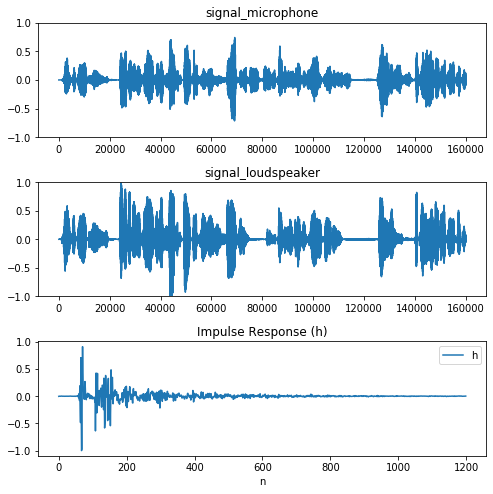

In [4]:
plot_signals(signal_microphone, signal_loudspeaker, impulse_response, None, None, N=1200)

In [5]:
# Loudspeaker signal
ipd.Audio(signal_loudspeaker.reshape(-1), rate=rate)

In [6]:
# Microphone signal
ipd.Audio(signal_microphone.reshape(-1), rate=rate)

### 3.2 Non-Adaptive Block Frequency-Domain Filtering

Before proceeding with the actual FDAF algorithm, to understand the fast convolution better, we have coded the BFDF routine. To test it, we have used the room impulse response to create y from speaker signal.


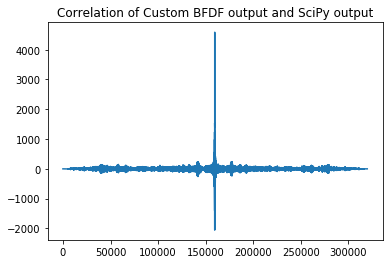

In [7]:
x = get_shifted_blocks(signal_loudspeaker,1024,512)
h = get_shifted_blocks(impulse_response,1024,512)
X = fft.fft(x)
H = fft.fft(h)
y = BFDF(X,H,512)
ipd.Audio(y.T,rate=rate)

plt.plot(sig.correlate(y,signal_microphone))
plt.title('Correlation of Custom BFDF output and SciPy output')
plt.show()

As the correlation shows, the outputs from two different convolution routines are practically identical.

### 3.3 Frequency-Domain Adaptive Filtering / Overlap and Save variant

We have implemented the algorithm as described in [1]. For experiments, we have decided to use the parameters as below.

|Parameter|Value|Justification|
|---|---|---|
|$\lambda$| $0.85$  | Should be between 0.5 and 1 for being agile enough |
|$S$ | $1200$ | We know the impulse response length and incorporate that information|
|$M$ | $2400$ | 2 x shift size|
|$\delta$ | $10^{-8}$ | A small regularization parameter in case energy in some frequency band is zero|
|$\mu$| $0.3$ | Learning rate should be less than 2 for convergence|


`freeze_index` = from 4th second until 10th second the adaptation is blocked.

In [8]:
fi = np.asarray([[4,10]])*2*rate
N = 1200
e, y, H, p, _, _, _ = FDAF_OS(signal_loudspeaker,signal_microphone, M=2*N, S=N, freeze_index=fi)

In [9]:
ipd.Audio(e.ravel(),rate=rate)

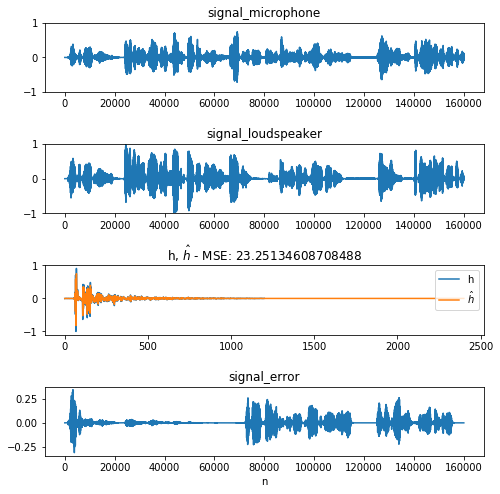

In [10]:
plot_signals(signal_microphone, signal_loudspeaker, impulse_response, e, np.pi*fft.ifft(H.ravel()).real, 1200)

After running the algorithm, we obtain an impulse response $\hat{h}(n)$ which is visually similar to $h(n)$. After roughly 3 seconds, the algorithm converges and we stop hearing the other speaker.

### 3.4 Double-talk detector inclusion

Omitting the `freeze_index` parameter results in algorithm using the double-talk detector. If double-talk is detected in a particular iteration then filter coefficients are not updated in that iteration. Additionally, single-talk is assumed during the first 20 blocks (around 1.5 seconds).

The table below summarizes chosen parameter values, which performed best in the experimental evaluation. All other parameters are equal to the ones in 3.3.

|Parameter|Value|
|---|---|
|$\lambda_c$| $0.8$  |
|$T_{ol}$| $0.85$  |
|$T_{cl}$| $0.95$  |

In [11]:
T_ol = 0.85
T_cl = 0.95
e, y, H, p, open_loop_xis, closed_loop_xis, adapt_flag = FDAF_OS(signal_loudspeaker, signal_microphone, \
                                                                 M=2*N, S=N, \
                                                                 open_loop_threshold=T_ol, closed_loop_threshold=T_cl, \
                                                                 lambda_coherence=0.8)

In [12]:
ipd.Audio(e.ravel(),rate=rate)

The following plots show the result of DTD inclusion:

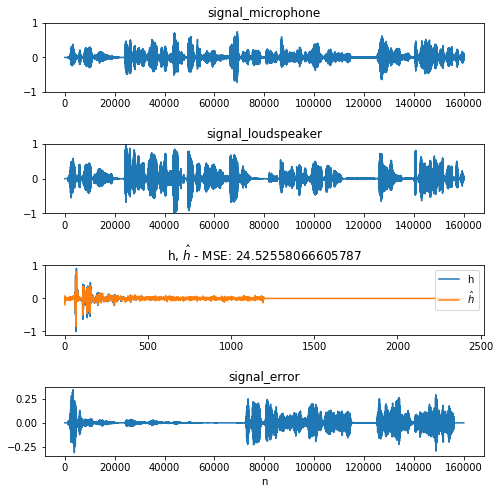

In [13]:
plot_signals(signal_microphone, signal_loudspeaker, impulse_response, e, np.pi*fft.ifft(H.ravel()).real, 1200)

<Figure size 432x288 with 0 Axes>

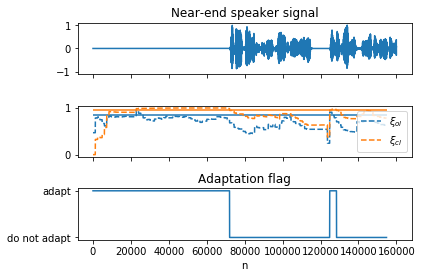

In [14]:
plot_dtd_results(near_end, N, open_loop_xis, closed_loop_xis, T_ol, T_cl, adapt_flag)

The straight horizontal lines on the plot with $\xi$ variables mark $T_{cl}$ and $T_{ol}$ from top to bottom respectively. The adaptation flag indicates when to update filter coefficients ('adapt') and when not ('do not adapt'). DTD correctly identifies single-talk up to the point when actual double-talk starts and then correctly switches to double-talk indication. It almost identifies correctly the second single-talk moment, but it is a little bit late. Although the resulting MSE of the impulse response is higher than without the DTD and the resulting audible effect is inferior to the previous one, it must be noted, that this adaptation algorithm is fully unsupervised in contrast to the 'freeze index' solution which implies some prior knowledge of the scenario at hand. It therefore (with certain improvements) could enable continuous running of the algorithm without the risk of adapting in the double-talk moments at a price of just a slight degradation in performance.

## 4. Conclusion

We have implemented frequency-domain filters: one non-adaptive and the other adaptive using the overlap-and-save method. We have also implemented an excitation-weighted mean magnitude square coherence-based double-talk detector to control filter's adaptation. The created experimental scenarios show that frequency-domain filtering is efficient and effective, the adaptation is correct and double-talk detection helpful for unsupervised adaptation.

## 5. References

[1] J. Shynk, Frequency-Domain and Multirate Adaptive Filtering, IEEE Signal Processing Magazine, January 1992.

[2] H. Buchner et. al., Robust Extended Multidelay Filter and Double-Talk Detector for Acoustic Echo Cancellation, IEEE Transactions on Audio, Speech and Language Processing, Vol. 14, No. 5 (Sepember 2006)

[3] T. Gänsler et. al., A Double-Talk Detector Based on Coherence, IEEE Transactions on Communications, Vol. 44, No. 11 (November 1996)

[4] E. Hänsler and G. Schmidt, Acoustic Echo and Noise Control: A Practical Approach, (John Wiley & Sons 2004)